In [ ]:
#=======================#
#       EXAMPLES        #
#=======================#

# mol_name = 'ethane'
# ethane = build.molecule('C2H6')
# dihedral_ids = [2, 0, 1, 6]
# mask = [0, 1, 0, 0, 0, 1, 1, 1]

# mol_name = 'fluoropropadiene'
# molecule = pubchem_atoms_search(smiles='FC=C=C')
# dihedral_ids = [4, 1, 2, 3]
# bond_ids = [1, 2]
# mask = [0, 0, 1, 1, 0, 1, 1, 1]

# mol_name = 'biphenyl'
# molecule = pubchem_atoms_search(smiles='C1=CC=C(C=C1)C2=CC=CC=C2')
# dihedral_symbol = 'CCCC'
# bond_ids = [0, 1]
# dihedral_ids = [2, 0, 1, 3]
# mask = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# mol_name = 'mol_25'
# molecule = pubchem_atoms_search(smiles='C1=CC(=O)NC(=C1)C2=CC=CO2')
# dihedral_symbol = 'OCCN'
# bond_ids = [4, 3]
# dihedral_ids = [0, 4, 3, 2]
# mask = [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,]

# mol_name = 'mol_76'
# molecule = pubchem_atoms_search(smiles='C1=CNC2=NC=NC(=C21)C3=CNN=C3')
# dihedral_symbol = 'CCCC'
# bond_ids = [8, 6]
# dihedral_ids = [12, 8, 6, 5]
# mask = [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]

# structure 23
# C1=CC(=O)NC(=C1)C2=COC=C2
# 5 6 8 9 --> 4, 5, 7, 8




In [ ]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.io import trajectory, write
from ase import build
from ase.data.pubchem import pubchem_atoms_search

In [85]:
def evaluate_dihedral(molecule, dihedral_ids, mask,  calculator_list, resolution=None, mol_name='', visualize=True):
    '''
    Definition
    ----------
    Evaluates the PES of the breaking of a bond.
    bond_ids contain the index of the atoms that form the bond. 

    resolution in angles of the scan (0 to 360), 1, 5, 10, 20, 40, 50, ...

    greate a dir with the conformers for reproducibility and its result
    '''

    # create the working directory
    work_dir = os.path.join(os.curdir, mol_name)
    if not os.path.isdir(work_dir):
        os.makedirs(work_dir)

    # define the number of conformers to generate
    points = int(360 / resolution)
    #if type(points) != int:
    #    print('THE RESOLUTION IS NOT COMPATIBLE! SHOULD DIVIDE 360.')
    print(f'performing {resolution} degree dihedral scan')
    dihedral_list = np.linspace(0., 360., points+1)

   
    # save the conformers to disk for reproducibility
    print(f'saving {points} conformers')
    for i in range(len(dihedral_list)):
        molecule.set_dihedral(dihedral_ids[0], dihedral_ids[1], dihedral_ids[2], dihedral_ids[3], angle=dihedral_list[i], mask=mask)
        write(os.path.join(work_dir, f'conf_{i}.xyz'), molecule)

        #if visualize:
        #    view(molecule, viewer='ase')

    # create a trajectory file for the scan (one calculator only)
    if len(calculator_list) == 1:
        traj_path = os.path.join(work_dir, 'dihedral_scan.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

    # compute the dihedrals
    print(f'computing {molecule[dihedral_ids[0]].symbol}{molecule[dihedral_ids[0]].index}-{molecule[dihedral_ids[1]].symbol}{molecule[dihedral_ids[1]].index}-{molecule[dihedral_ids[2]].symbol}{molecule[dihedral_ids[2]].index}-{molecule[dihedral_ids[3]].symbol}{molecule[dihedral_ids[3]].index} PES')
    print(f'evaluating {len(dihedral_list)} conformers')
    print(f'dihedrals:\n{dihedral_list}\n')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dihedral_list:

            # define the configuration
            molecule.set_dihedral(dihedral_ids[0], dihedral_ids[1], dihedral_ids[2], dihedral_ids[3], angle=d, mask=mask)
            molecule.calc = calc_
            potential_e = molecule.get_potential_energy()
            calc_energy_list.append(potential_e)
        
            if len(calculator_list) == 1:
                traj.write(molecule)

        # compute reference
        # TODO

        energies.append(calc_energy_list)

        if len(calculator_list) == 1:
            traj.close()
    
    if visualize:
        traj = trajectory.TrajectoryReader(os.path.join('./', mol_name, 'dihedral_scan.traj'))
        view(traj, viewer='ase')

    return dihedral_list, energies



def plot_dihedral(dihedral_list, energy_list, calculator_names, calculator_colors, mol_name='', dihedral_symbol=''):
    '''
    Plot a dihedral scan. 
    '''

    work_dir = os.path.join(os.curdir, mol_name)

    _color_list = ['black', 'red', 'orange', 'blue']
    _marker_list = ['^', 'd', 'v', 'o']

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6,4)) 
    axes.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_names)):
        
        # gather the minimum energy structure
        idx = np.argmin(energy_list[k][:])
        min_energy = energy_list[k][idx]
        min_dih = dihedral_list[idx]

        # TODO convert energy from eV/particle to kcal/mol: 1 eV/molecule = 23.0605 kcal/mol

        axes.plot(dihedral_list, (np.array(energy_list[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)
        axes.scatter(min_dih, min_energy-min_energy, color=_color_list[k], marker=_marker_list[k], label=r'$\textnormal{energy ref @ ' + f'{min_dih:.0f}' + r' deg}$')

    # add a text to the plot with the name of the molecule on the top right

    axes.set(xlabel=r'$\textnormal{' + f'{mol_name} {dihedral_symbol}' + r' dihedral angle}\;\textnormal{(deg)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')
    #r'$\textnormal{' + f'{mol_name}' + r'}$'
    #axes.text(.03, .97, f'{mol_name}', ha='left', va='top', transform=axes.transAxes, size='large', weight='bold')
    axes.legend(loc='best', title=f'{mol_name}', title_fontsize='large')

    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{dihedral_symbol}'+'dihedral_PES.png'), dpi=300)
    plt.show(fig)

In [86]:
#=======================#
#       CALCULATOR      #
#=======================#

from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

calculator_list = [macemp, maceoff]
calculator_names = ['MACE-MP', 'MACE-OFF']
calculator_colors = ['deeppink', 'darkgreen']

calculator_list = [maceoff]
calculator_names = ['MACE-OFF']

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [153]:
#=======================#
#       PARAMETERS      #
#=======================#



# mol_name = 'mol_76'
# molecule = pubchem_atoms_search(smiles='C1=CNC2=NC=NC(=C21)C3=CNN=C3')
# dihedral_symbol = 'CCCC'
# bond_ids = [8, 6]
# dihedral_ids = [12, 8, 6, 5]
# mask = [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]



# define the molecule
mol_name = 'mol_23'


#molecule = build.molecule('C2H6')
#molecule = pubchem_atoms_search(name='ethane')
molecule = pubchem_atoms_search(smiles='C1=CC(=O)NC(=C1)C2=COC=C2')

for atom in molecule:
    print(atom.index, atom.symbol)
view(molecule, viewer='ase')

# 2 [0 1] 6 dihedral, [0 1] is the rotatable bond
dihedral_symbol = 'NCCC'
bond_ids = [4, 3]
dihedral_ids = [7, 4, 3, 2]

# TODO CREATE THE MASK AUTOMATICALLY with neighbour list....
mask = [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0]
print(len(mask))

molecule.set_dihedral(dihedral_ids[0], dihedral_ids[1], dihedral_ids[2], dihedral_ids[3], 90, mask=mask)
#view(molecule, viewer='ase')

0 O
1 O
2 N
3 C
4 C
5 C
6 C
7 C
8 C
9 C
10 C
11 C
12 H
13 H
14 H
15 H
16 H
17 H
18 H
19


2025-02-07 15:31:40.521 python[35669:562751] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-07 15:31:40.521 python[35669:562751] +[IMKInputSession subclass]: chose IMKInputSession_Modern


performing 10 degree dihedral scan
saving 36 conformers
computing C7-C4-C3-N2 PES
evaluating 37 conformers
dihedrals:
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360.]



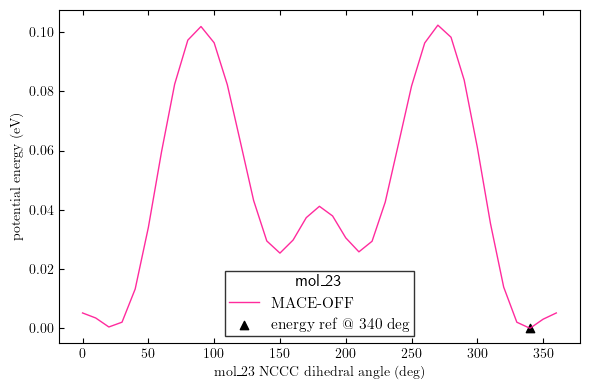

In [150]:
dihedrals, energies = evaluate_dihedral(molecule, dihedral_ids, mask,  calculator_list, resolution=10, mol_name=mol_name, visualize=False)
plot_dihedral(dihedrals, energies, calculator_names, calculator_colors, mol_name=mol_name, dihedral_symbol=dihedral_symbol)

In [154]:
traj = trajectory.TrajectoryReader(os.path.join('./', mol_name, 'dihedral_scan.traj'))
view(traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_MACE/lib/pyt